In [1]:
import numpy as np
from PIL import Image as im
from PIL import ImageOps as imo
from numpy.lib.stride_tricks import sliding_window_view

In [2]:
def rot(old_coord):
    # Input: Last relative coordinate
    # Output: Next relative coordinate
    last = old_coord
    if   (last == (-1,-1)):
        return    (-1, 0)
    elif (last == (-1, 0)):
        return    (-1, 1)
    elif (last == (-1, 1)):
        return    (0, 1)
    elif (last == (0, 1)):
        return    (1, 1)
    elif (last == (1, 1)):
        return    (1, 0)
    elif (last == (1, 0)):
        return    (1, -1)
    elif (last == (1, -1)):
        return    (0, -1)
    else:
        return    (-1, -1)

In [3]:
def next_coord(coord, edges, last_coord):
    # Input: x,y coordinate of current pixel
    #        set of all edges
    #        last pixel seen
    # Output: next pixel in clockwise order
    (y,x) = coord
    (last_y, last_x) = last_coord
    rel_coord = (last_y - y, last_x - x)
    for _ in range(8): # Was 7
        (diff_y, diff_x) = rot(rel_coord)
        if (tuple([y + diff_y, x + diff_x]) in edges): #true if an edge
            return (y + diff_y, x + diff_x)
        rel_coord = (diff_y, diff_x)
    return None

In [4]:
def outline(start, edges):
    # Input: start edge, possible connecting edges
    # Output of the pixels on the border of image
    # in clockwise order
    (y,x) = start
    last = (0,0)
    (offset_y, offset_x) = (1, 0)
    last = (y+offset_y, x+offset_x)
    
    #ToDO Find the side that has white on it
        
    next_ = next_coord(start, edges, last) # wrong
    # better way to correct for next_
    
    
    last = start
    border = [start]
    border_set = set(start)
    while(True):
        if (next_ == None or next_ == start):#or next_ in border_set):
            break
        else:
            border.append(next_)
            border_set.add(next_)
            new_next = next_coord(next_, edges, last)
            last = next_
            next_ = new_next
    #print(border)      
    return border

In [5]:
def plot_borders(borders, size):
    temp = np.zeros(shape=size)
    for border in borders:
        for (y,x) in border:
            temp[y,x] = 255

    temp = temp.astype(np.uint8)
    img = im.fromarray(temp)
    display(img)

In [114]:
name = "1"
figure_img = im.open(f"imgs/test_document-{name}.png")
figure_img = imo.grayscale(figure_img)
#figure_img = figure_img.rotate(270, expand=True)
figure = np.asarray(figure_img) / 255
img = im.fromarray(np.uint8(figure * 255), 'L')

In [115]:
imfft = np.fft.fft2(figure*255)
mags = np.abs(np.fft.fftshift(imfft))
angles = np.angle(np.fft.fftshift(imfft))
visual = np.log(mags)
visual2 = (visual - visual.min()) / (visual.max() - visual.min())*255
img = im.fromarray(np.uint8(visual2 ), 'L')

In [117]:
mask = visual2.copy()
#mask = (np.mean(mask,-1) > 50)
#print(mask.all(), mask.any())
temp = (np.mean(mask, -1) > 100)
print(temp.any(), temp.all())
visual[temp] = np.mean(visual)

True False


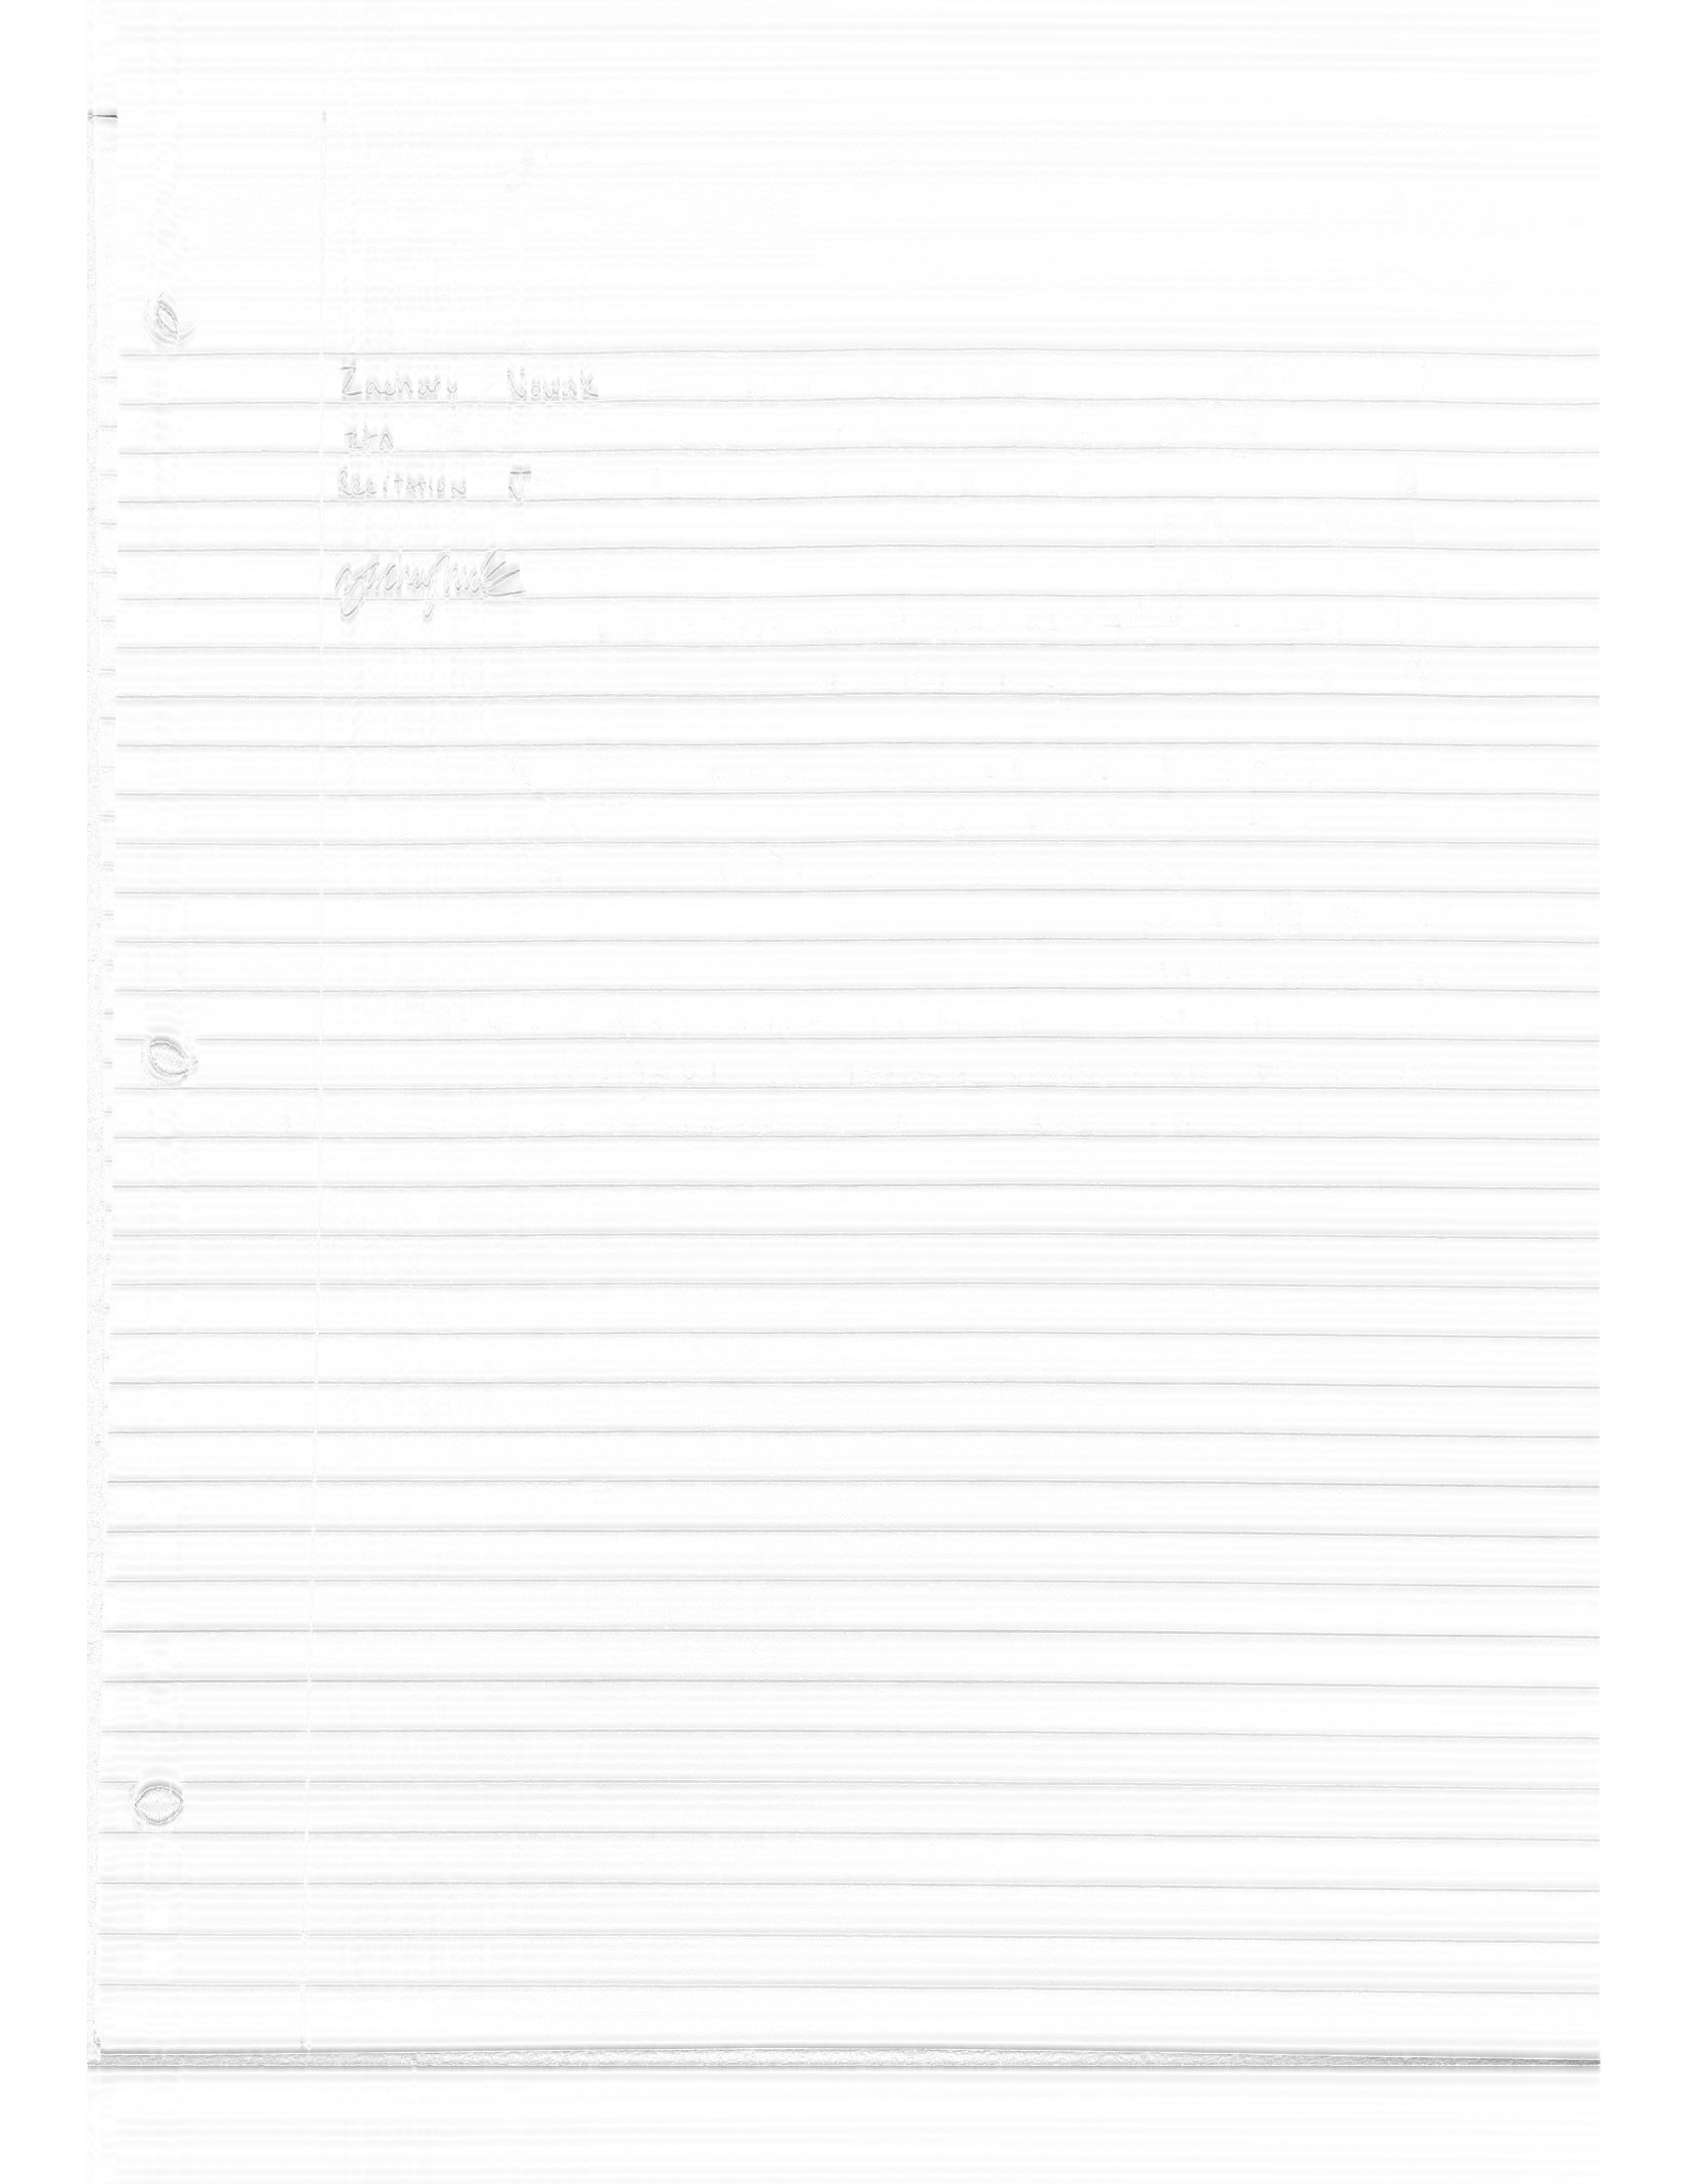

In [122]:
newmagsshift = np.exp(visual)
newffts = newmagsshift * np.exp(1j*angles)
newfft = np.fft.ifftshift(newffts)
imrev = np.fft.ifft2(newfft)
newim2 = 255 - np.abs(imrev).astype(np.uint8)
img = im.fromarray(np.uint8(newim2), 'L')
img

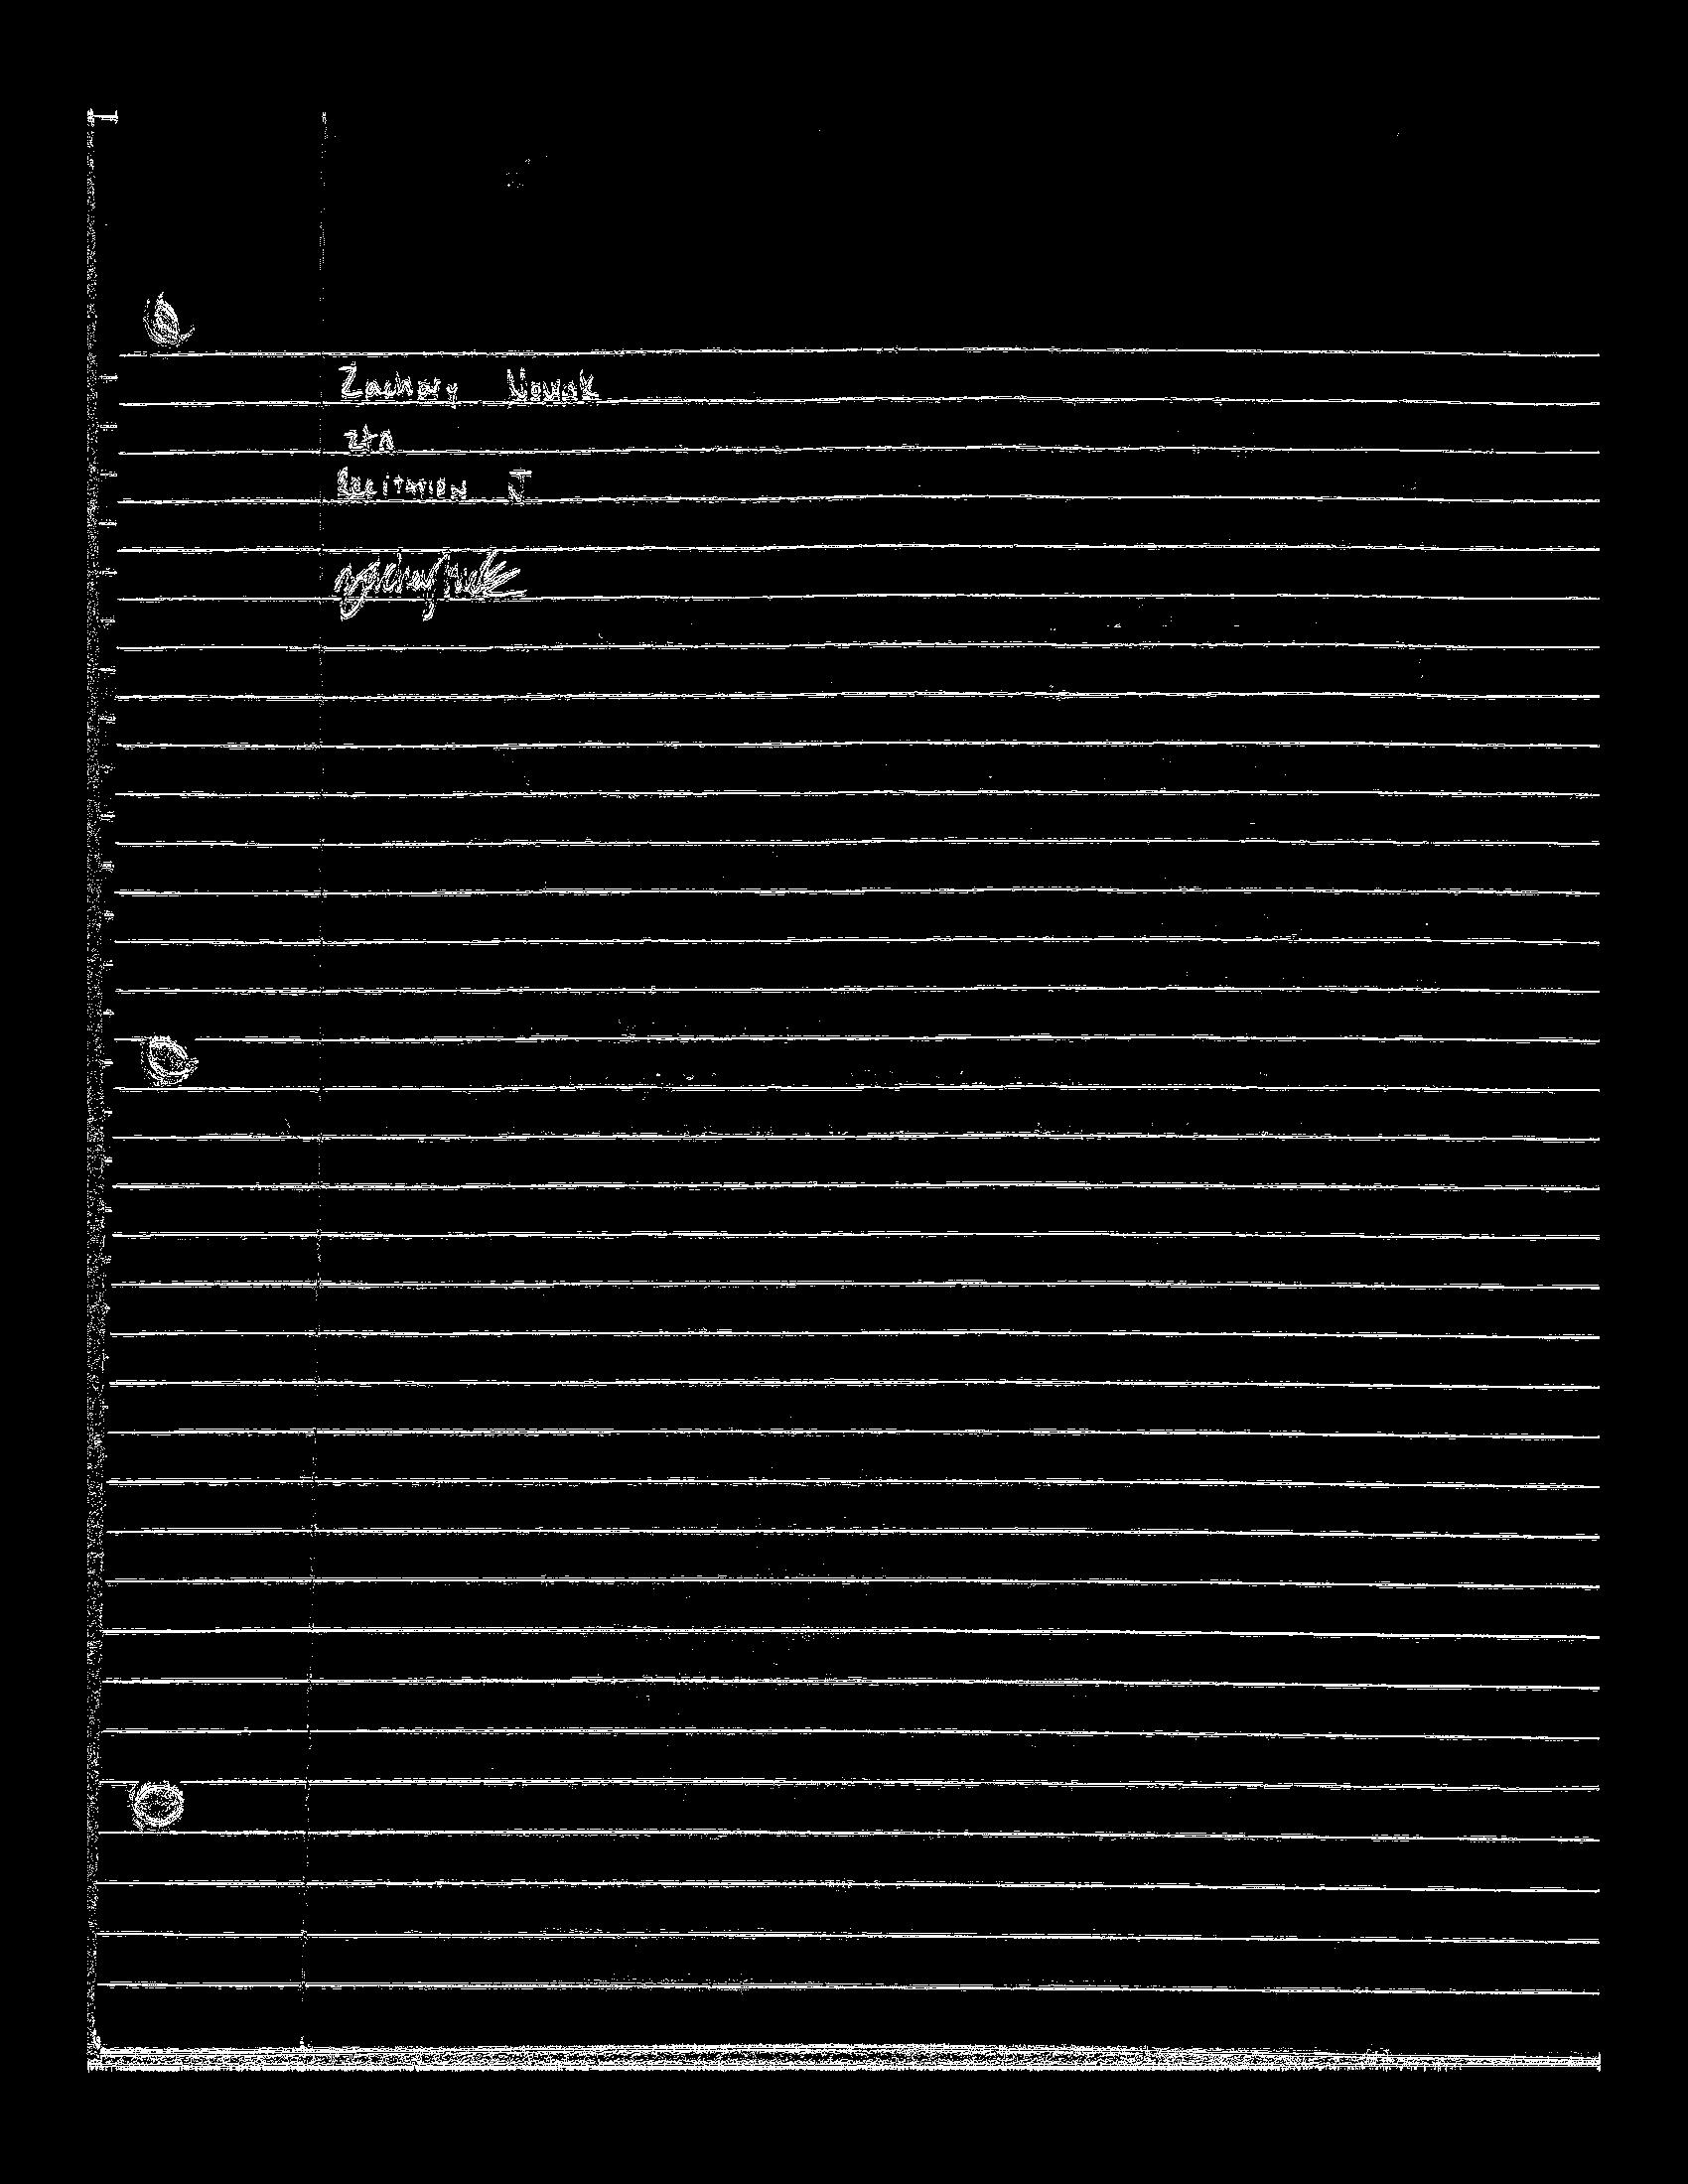

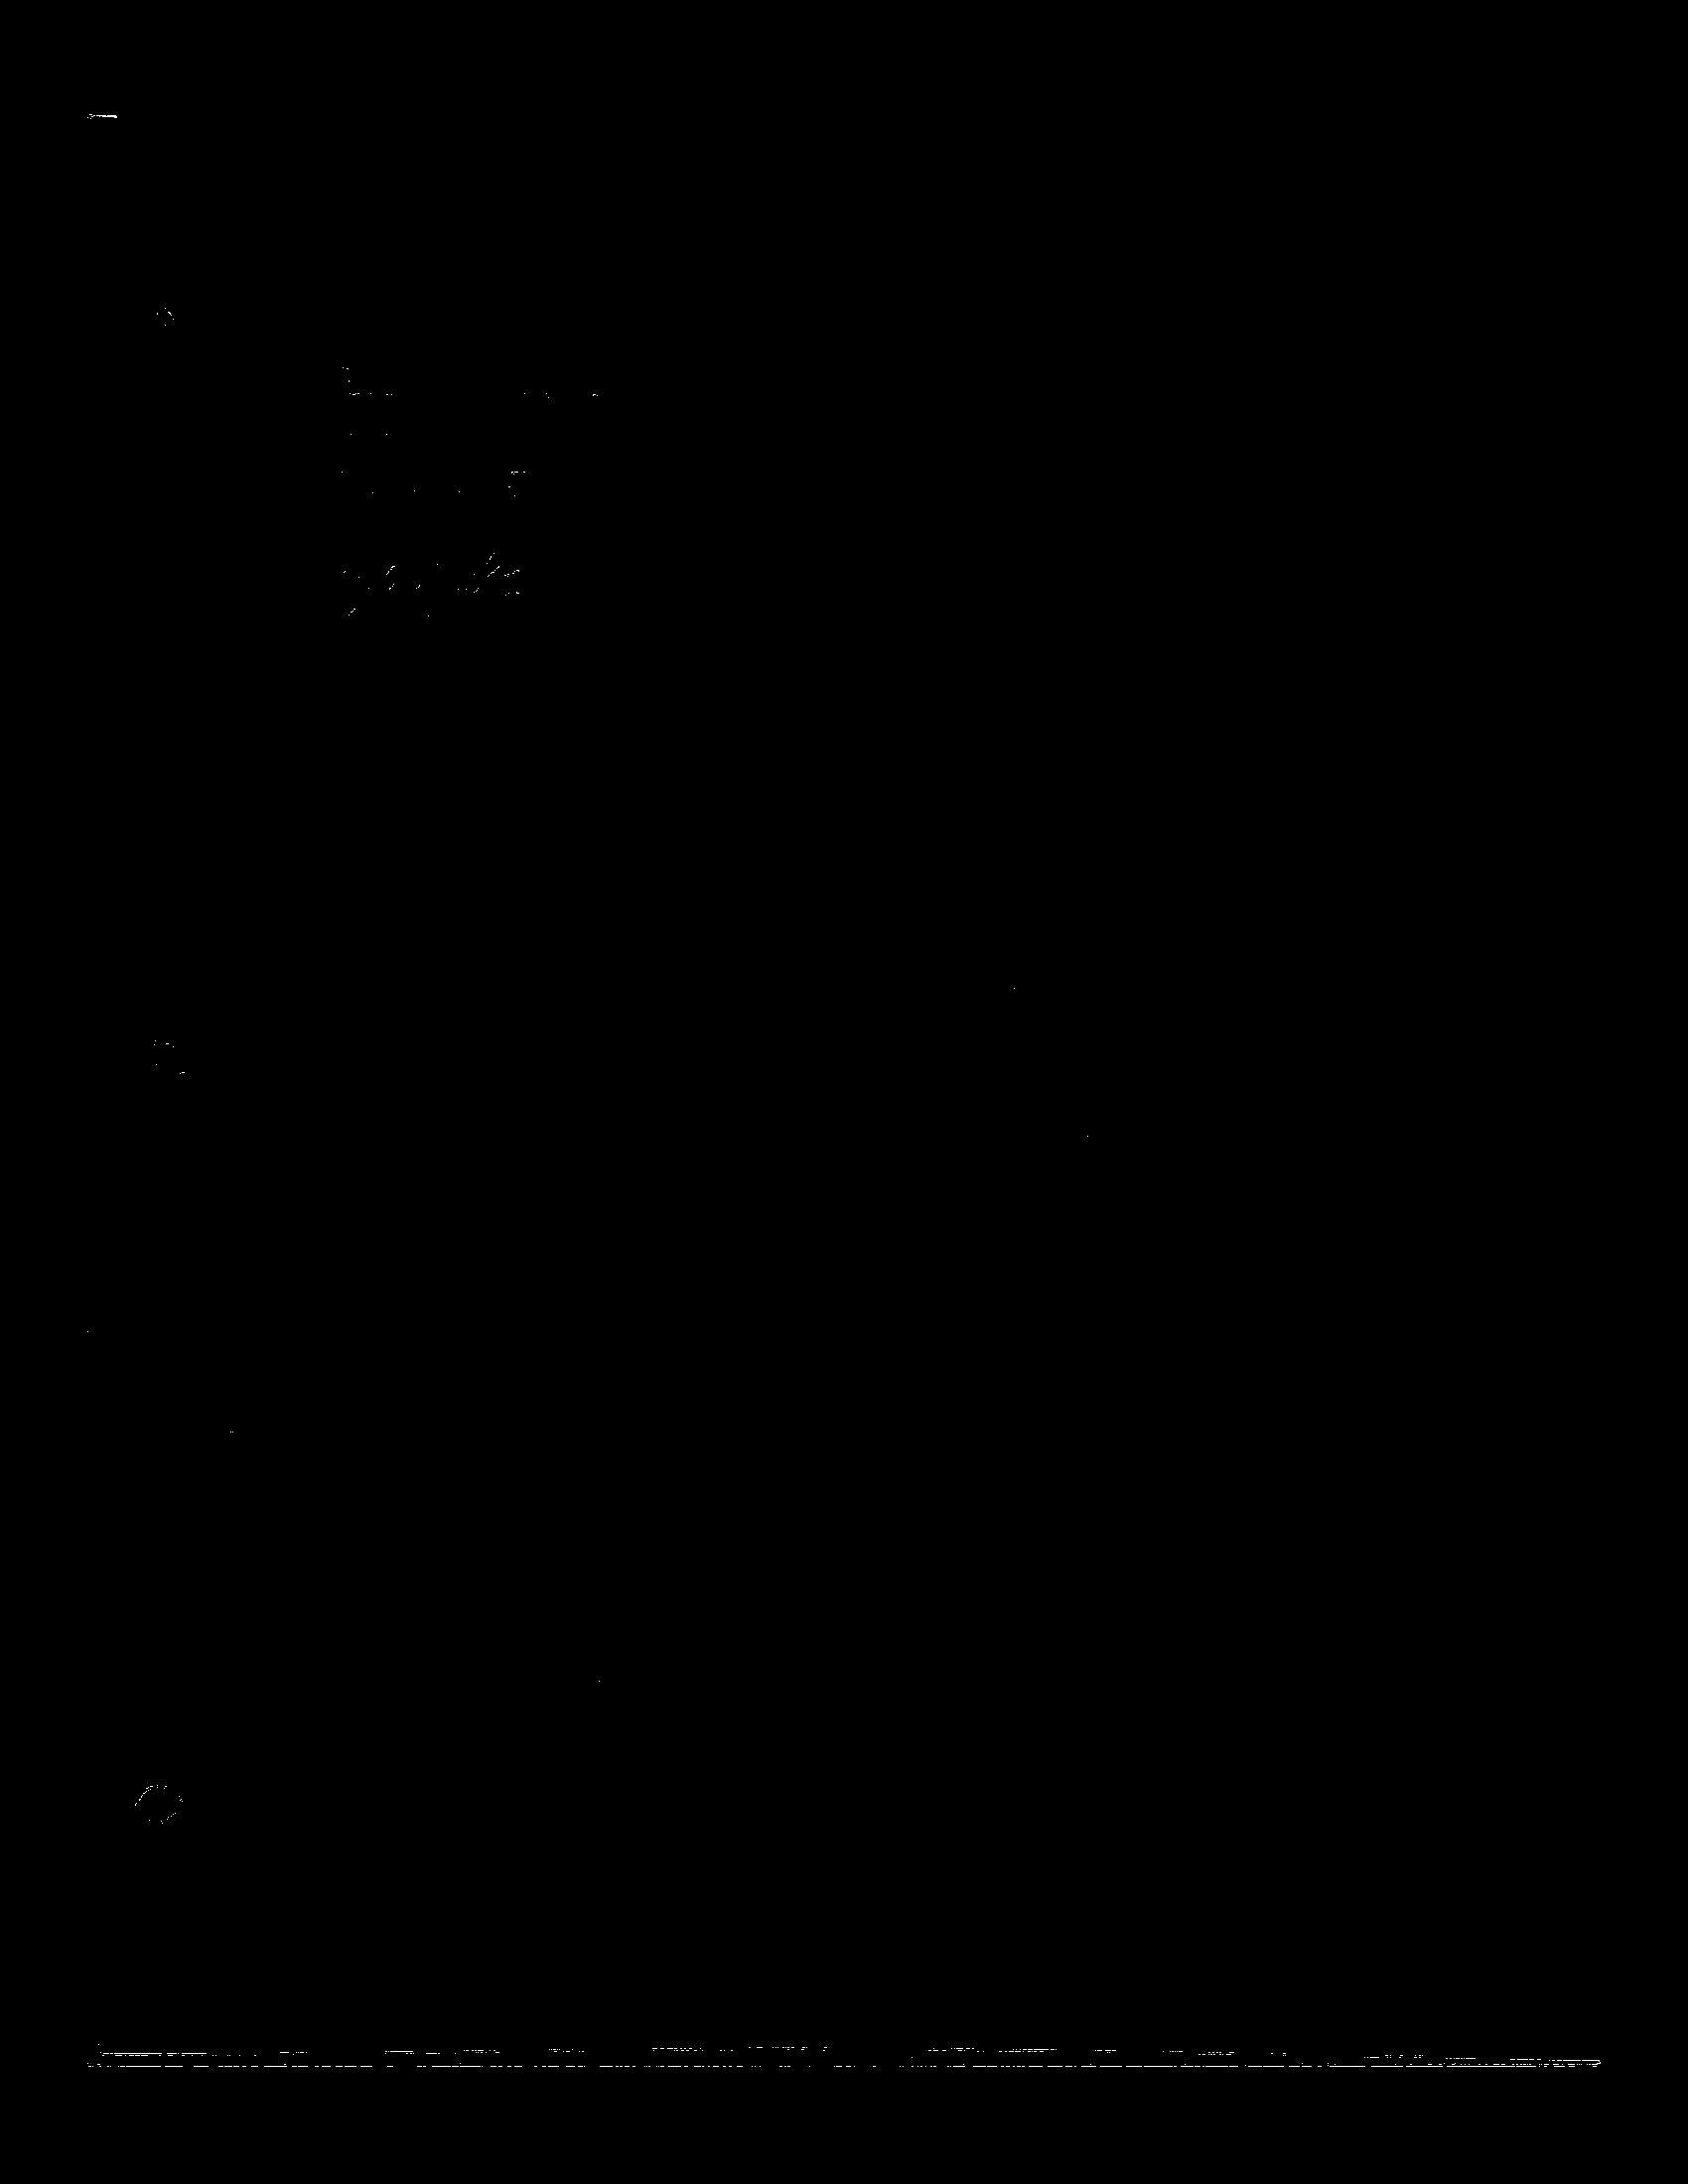

In [123]:
# All Edges
figure =  np.asarray(newim2) / 255
pixels = sliding_window_view(figure, (3,3))
number_of_pixels = pixels.shape[0] * pixels.shape[1]
shape = (pixels.shape[0], pixels.shape[1])
white = np.reshape(pixels, (number_of_pixels,9)).max(axis=-1).reshape(shape)
edges = np.pad(white, pad_width=1, mode='constant')
np.subtract(edges,figure,out=edges)
np.greater_equal(edges, 0.04, out=edges) # contrast
img = im.fromarray(np.uint8(edges * 255), 'L')
display(img)

# Critical Edges
pixels = sliding_window_view(figure, (3,3))
number_of_pixels = pixels.shape[0] * pixels.shape[1]
shape = (pixels.shape[0], pixels.shape[1])
white = np.reshape(pixels, (number_of_pixels,9)).max(axis=-1).reshape(shape)
crit_edges = np.pad(white, pad_width=1, mode='constant')
np.subtract(crit_edges,figure,out=crit_edges)
np.greater_equal(crit_edges, 0.2, out=crit_edges) # contrast
img = im.fromarray(np.uint8(crit_edges * 255), 'L')
display(img)

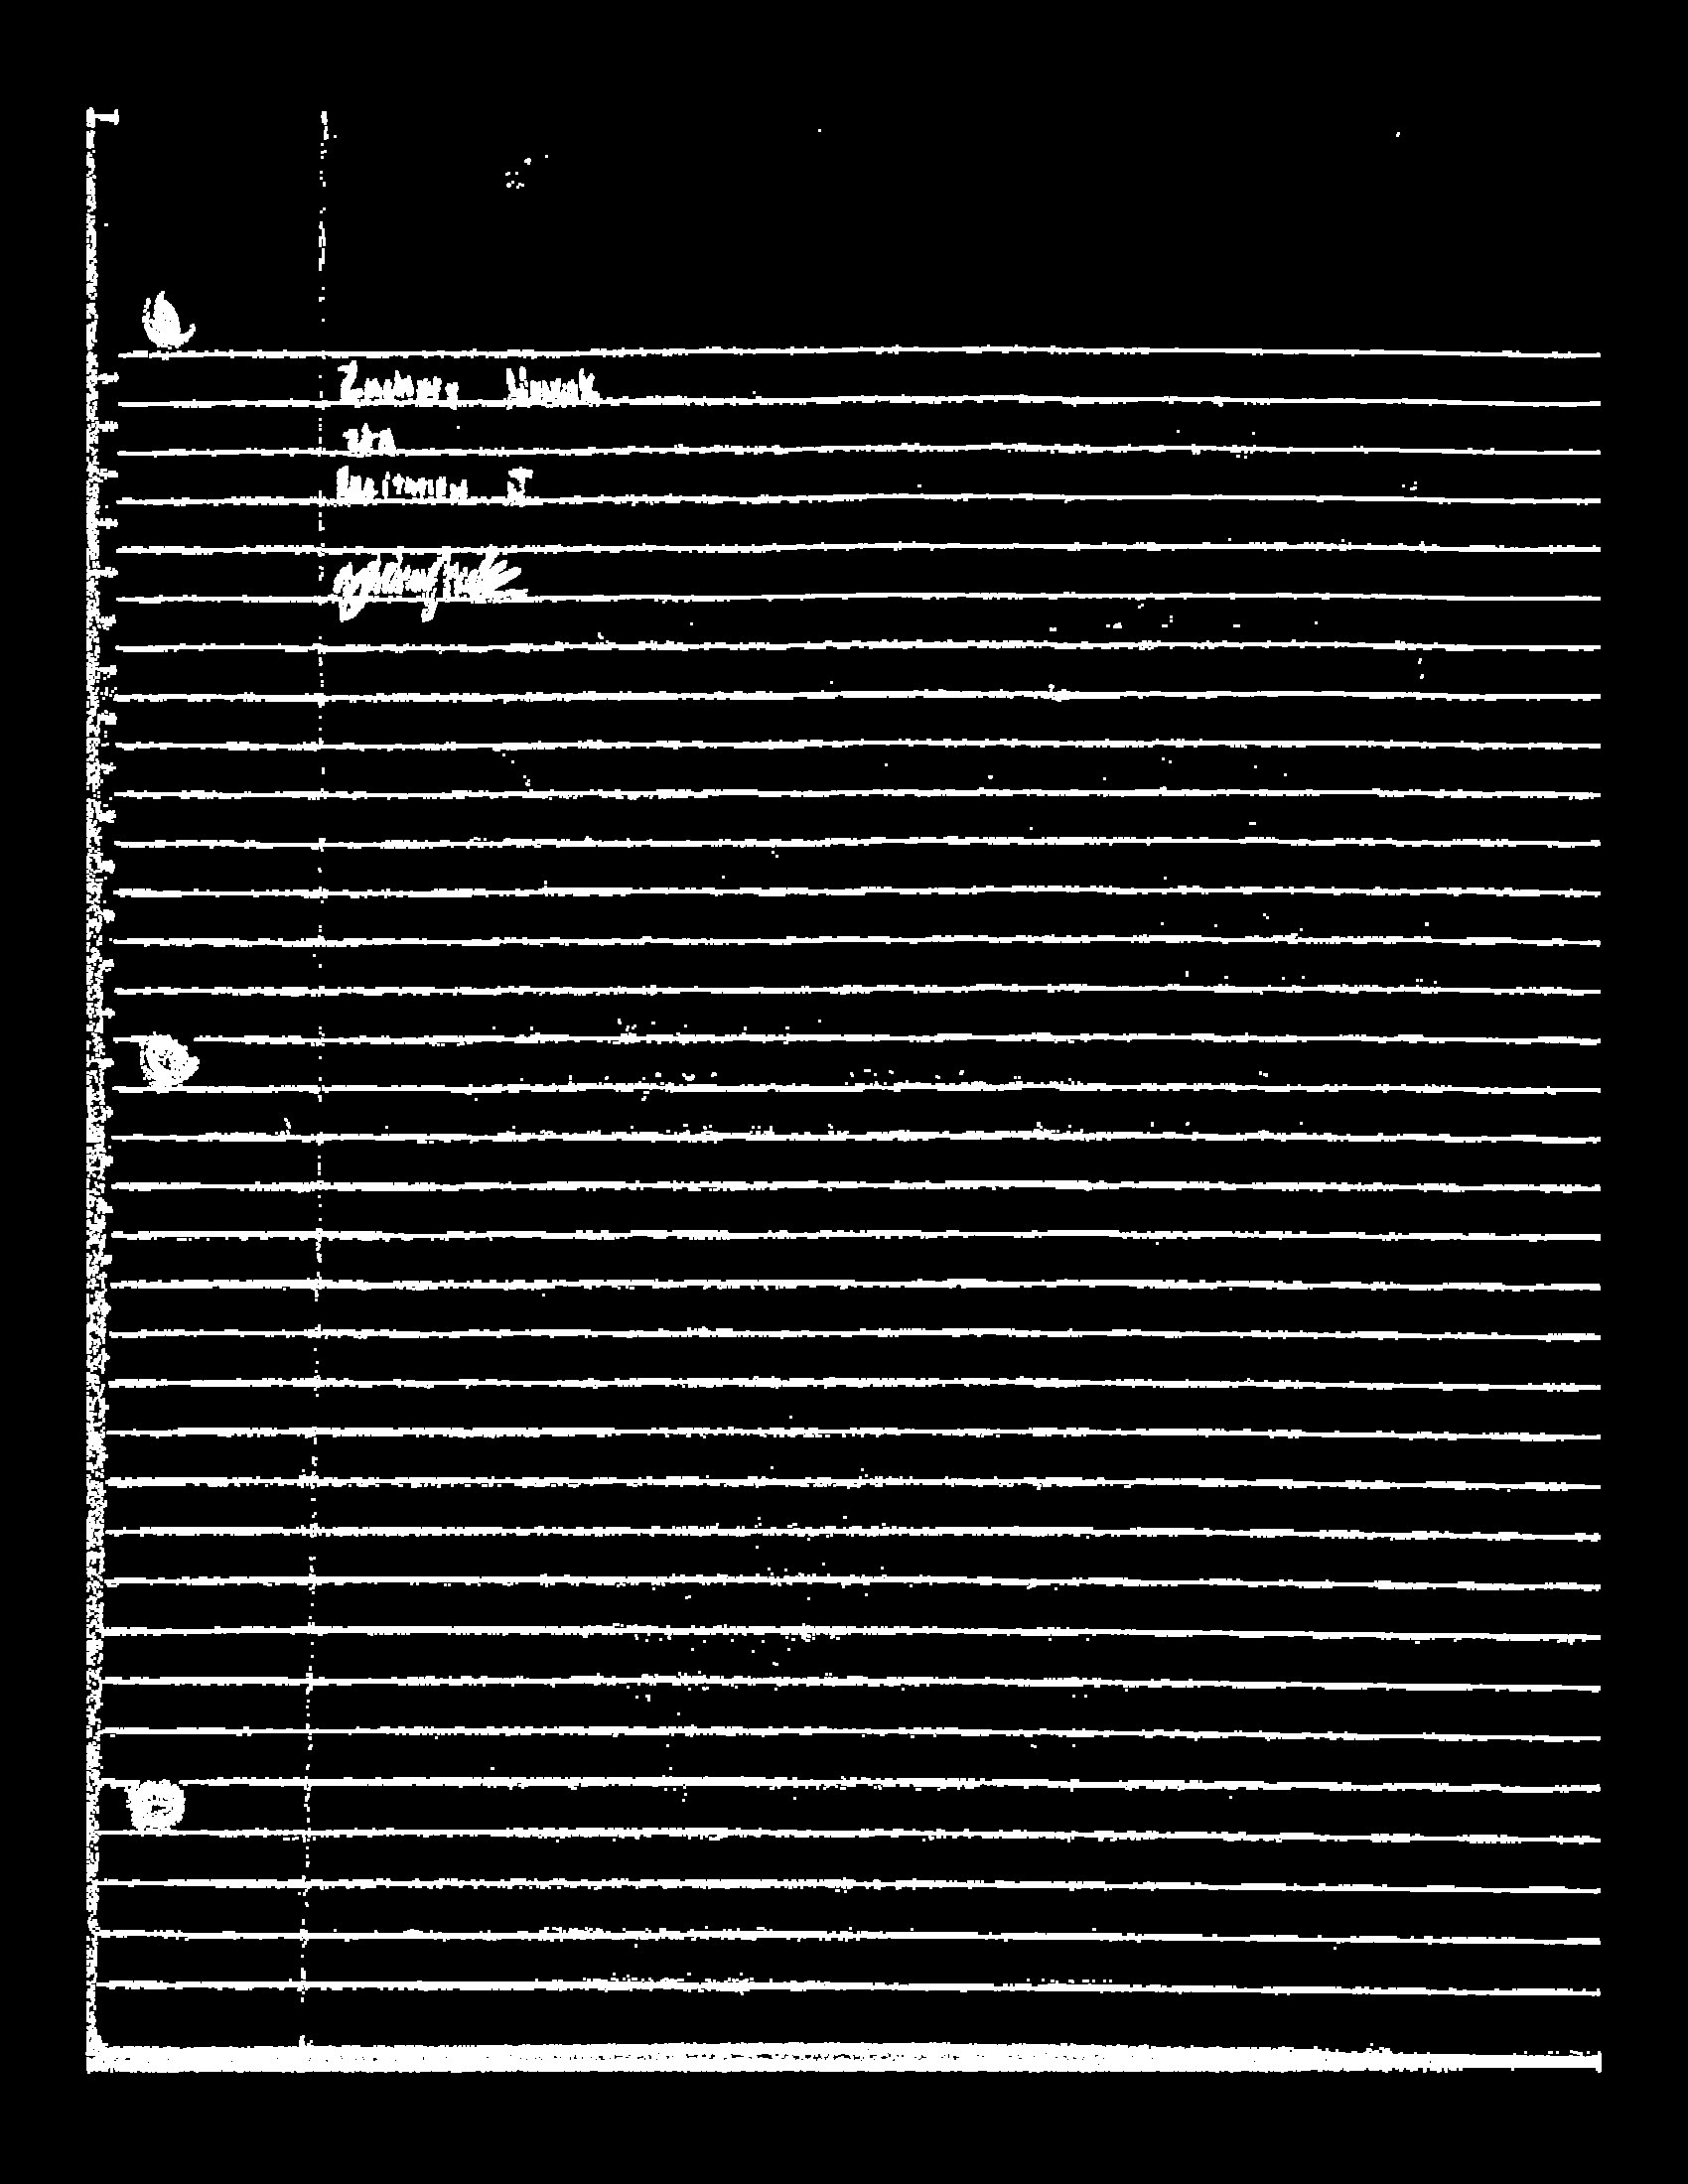

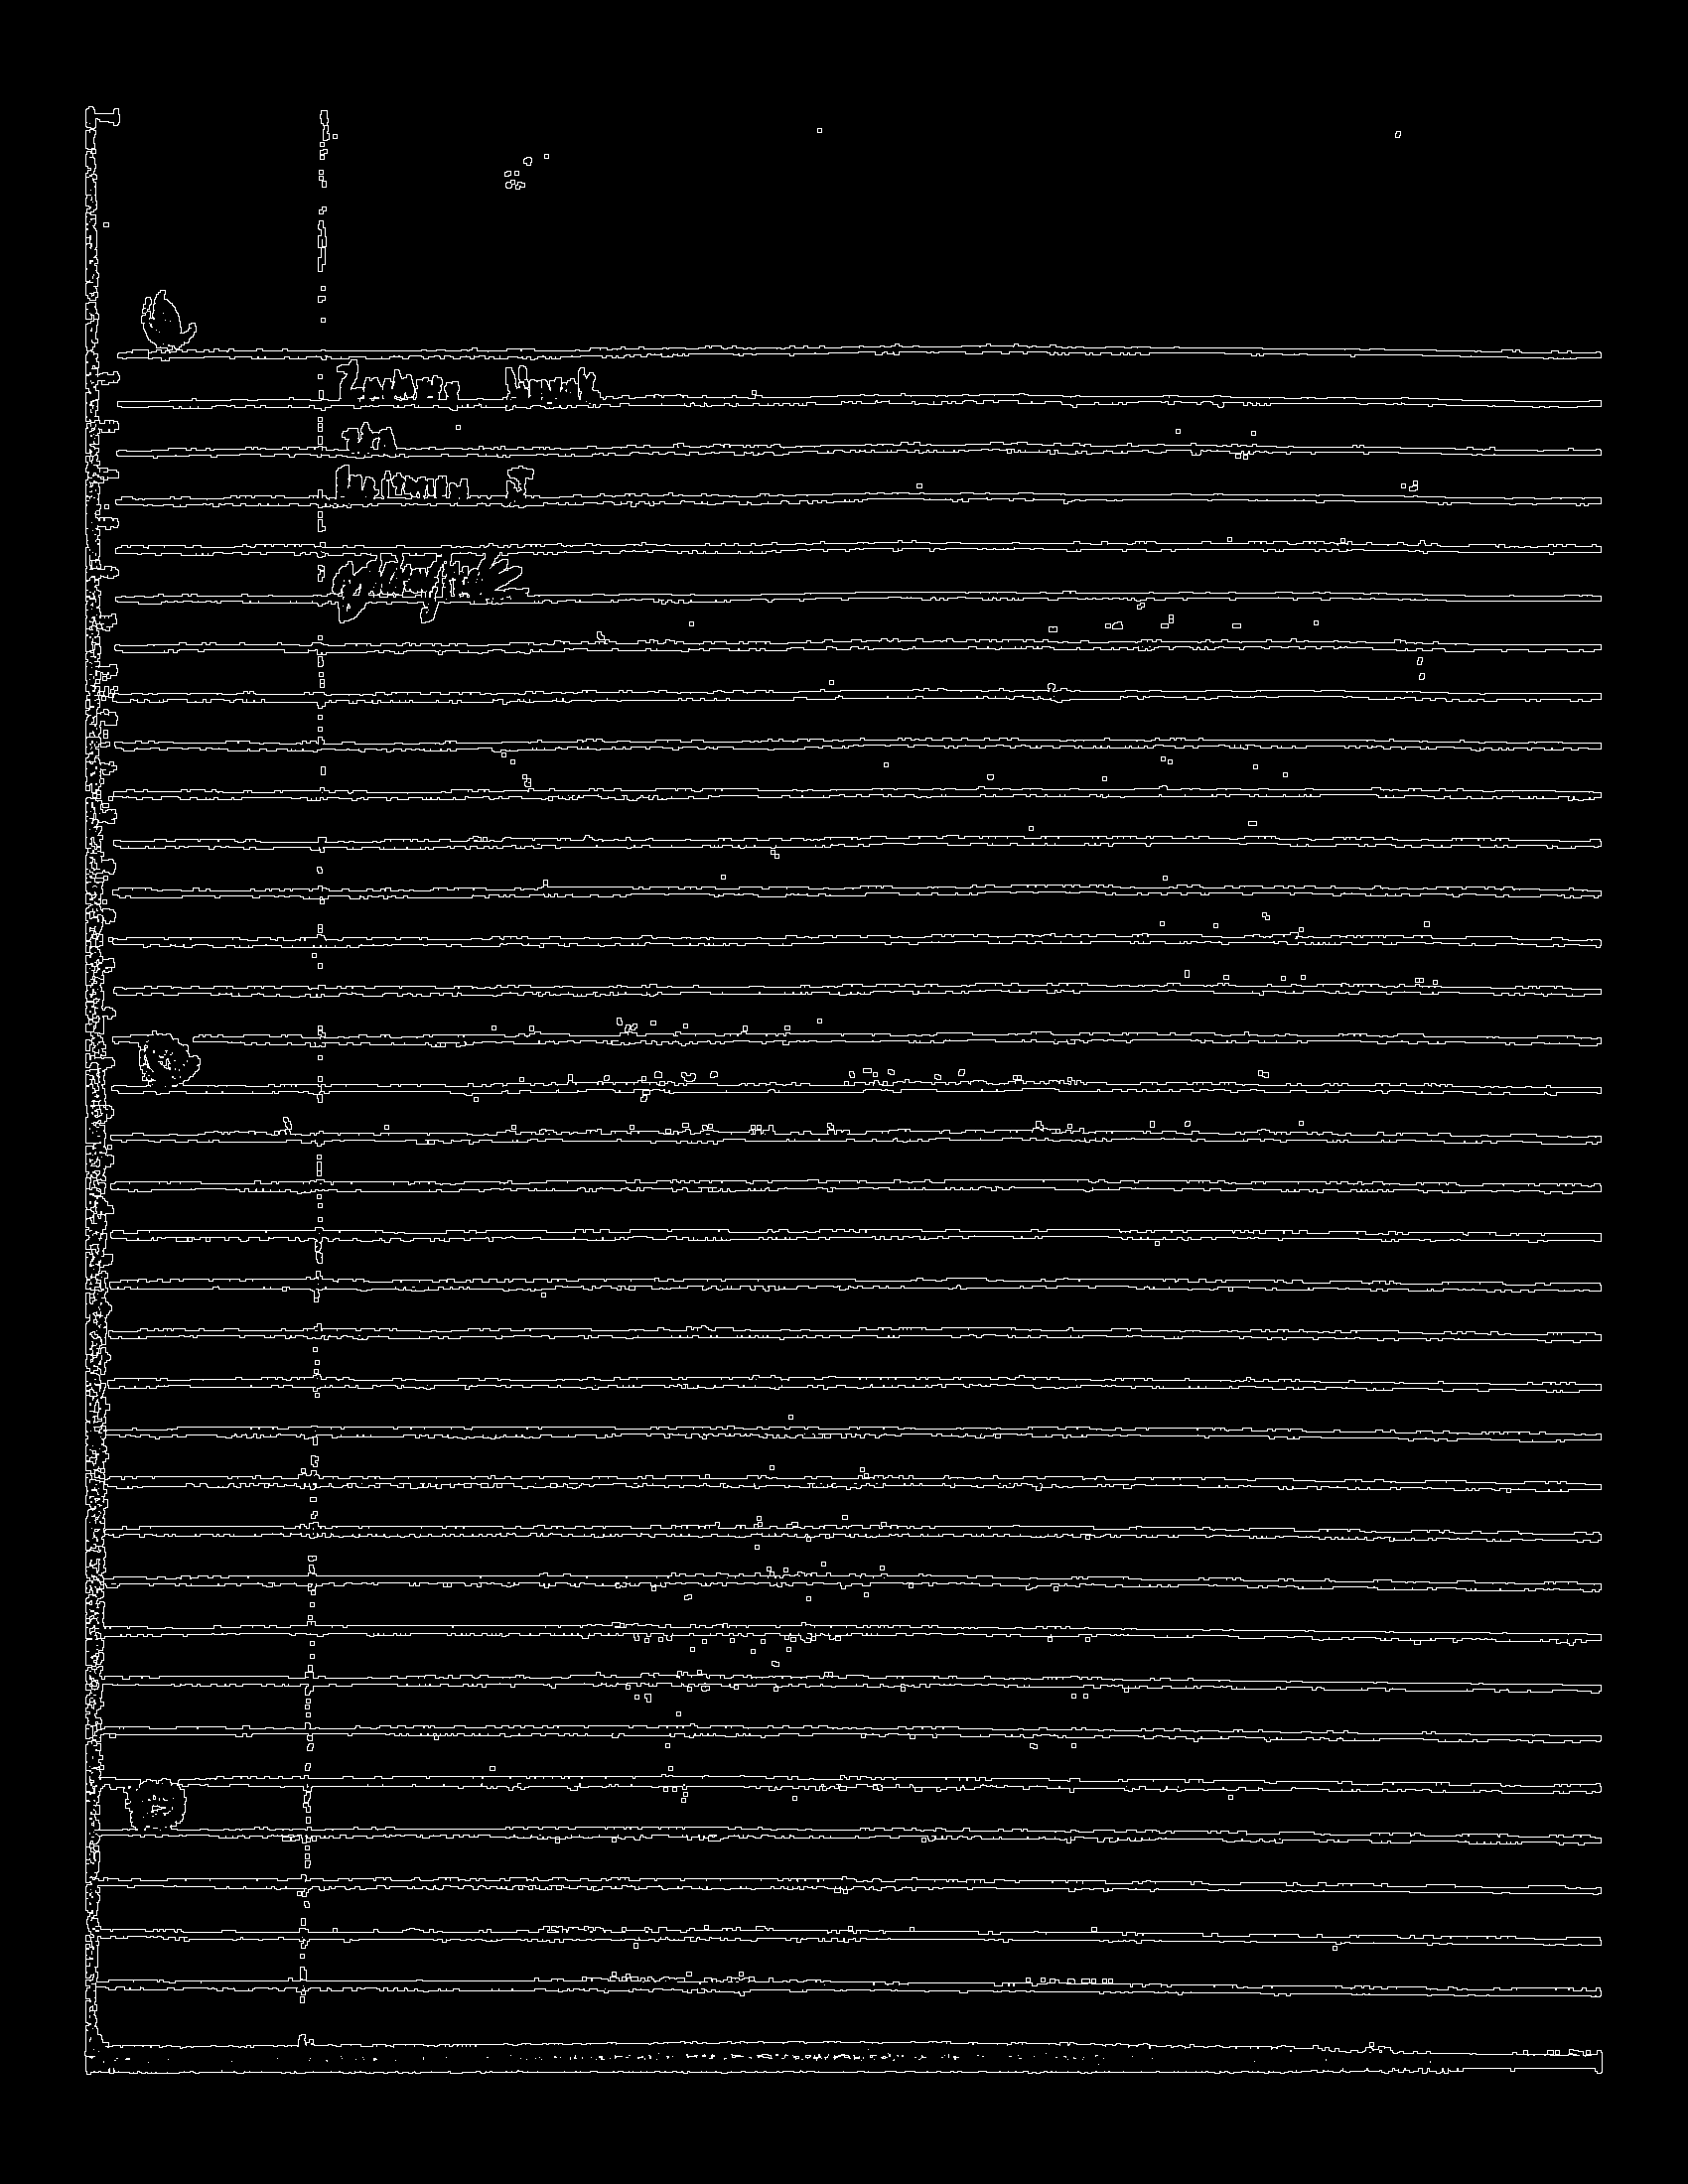

407125
148108


In [124]:
# BLUR
n = 3 #odd number
pixels = sliding_window_view(edges, (n,n))
number_of_pixels = pixels.shape[0] * pixels.shape[1]
shape = (pixels.shape[0], pixels.shape[1])
blur = np.reshape(pixels, (number_of_pixels,n**2)).max(axis=-1).reshape(shape)
blur = np.pad(blur, pad_width=1, mode='constant')
img = im.fromarray(np.uint8(blur * 255), 'L')
display(img)

# Critical Edges
pixels = sliding_window_view(blur, (3,3))
number_of_pixels = pixels.shape[0] * pixels.shape[1]
shape = (pixels.shape[0], pixels.shape[1])
white = np.reshape(pixels, (number_of_pixels,9)).max(axis=-1).reshape(shape)
blur_edges = np.pad(white, pad_width=1, mode='constant')
np.subtract(blur_edges,blur,out=blur_edges)
np.greater_equal(blur_edges, 0.01, out=blur_edges) # contrast
img = im.fromarray(np.uint8(blur_edges * 255), 'L')
display(img)
print(np.count_nonzero(blur == 1))
print(np.count_nonzero(blur_edges == 1))